<a href="https://colab.research.google.com/github/reetibhagat/Capstone-project2/blob/master/cnn_with_generated_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align: center;font-size: 40px;">Pneumonia Detection from Chest X-Ray images</h1>

---

<center><img src="https://www.drugs.com/health-guide/images/022dc126-fc5d-4e54-9a78-75f2c9ea4bb6.jpg
"width="500" height="600"></center>


><h3>What is Pneumonia??</h3>

>> Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.

><h3>Symptoms</h3>

>> The signs and symptoms of pneumonia vary from mild to severe, depending on factors such as the type of germ causing the infection, and your age and overall health. Mild signs and symptoms often are similar to those of a cold or flu, but they last longer.

Signs and symptoms of pneumonia may include:

- Chest pain when you breathe or cough
- Confusion or changes in mental awareness (in adults age 65 and older)
- Cough, which may produce phlegm
- Fatigue
- Fever, sweating and shaking chills
- Lower than normal body temperature (in adults older than age 65 and people with weak immune systems)
- Nausea, vomiting or diarrhea
- Shortness of breath

Newborns and infants may not show any sign of the infection. Or they may vomit, have a fever and cough, appear restless or tired and without energy, or have difficulty breathing and eating.

Today we are going to apply CNN model on X-Ray images of chest. Dataset is imbalanced (approx. 1:3), images may have different site and can have one or 3 color channels.

At start, we will preprocess our data in very simple and intuitive way (load, resize, convert to grayscale, create labels). Model is using grayscale images as for me it did not make too much sense to use X-Ray images as colorful images.

In [3]:
#connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Downloading the Dataset

In [4]:
!ls '/content/drive/My Drive/capstone_2/chest_xray/'

chest_xray  __MACOSX  test  train  val


In [5]:
!ls '/content/drive/My Drive/capstone_2/chest_xray/chest_xray/'

test  train  val


**Importing necesssary packages**

In [ ]:
#pip install opencv-python
#pip install keras

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import random as rn
import seaborn as sns
import cv2
#import pandas.util.testing as tm
import glob

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,Activation
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop ,Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,confusion_matrix

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [ ]:
#setting seeds for reproducibility
seed=234
np.random.seed(seed)
tf.random.set_seed(seed)

**Loading Datasets**

In [7]:
import os
print(os.listdir('/content/drive/My Drive/capstone_2/chest_xray/chest_xray/'))

['.DS_Store', 'train', 'test', 'val']


In [ ]:
# assigning variables with the proper file path for the training, validation and test set
data_path= '/content/drive/My Drive/capstone_2/chest_xray/chest_xray/'


In [ ]:
# define paths
train_normal_dir = data_path + 'train/NORMAL/'
train_pneu_dir = data_path + 'train/PNEUMONIA/'

test_normal_dir = data_path + 'test/NORMAL/'
test_pneu_dir = data_path + 'test/PNEUMONIA/'

val_normal_dir = data_path + 'val/NORMAL/'
val_pneu_dir = data_path + 'val/PNEUMONIA/'

In [ ]:
dir = [train_normal_dir, train_pneu_dir, val_normal_dir,
            val_pneu_dir, test_normal_dir, test_pneu_dir]
dir_name = ['train_normal_dir', 'train_pneumonia_dir', 'val_normal_dir',
            'val_pneumonia_dir', 'test_normal_dir', 'test_pneumonia_dir']
for name, dir in zip(dir_name, dir):
  num_of_images = len(os.listdir(dir))
  print ('Number of images in {}: {}'.format(name, num_of_images))

Number of images in train_normal_dir: 1342
Number of images in train_pneumonia_dir: 3876
Number of images in val_normal_dir: 9
Number of images in val_pneumonia_dir: 9
Number of images in test_normal_dir: 234
Number of images in test_pneumonia_dir: 390


In [ ]:
# find all files, our files has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob( train_pneu_dir+ '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')


train_normal_cases = [x.replace('\\', '/') for x in train_normal_cases]
train_pneu_cases = [x.replace('\\', '/') for x in train_pneu_cases]
test_normal_cases = [x.replace('\\', '/') for x in test_normal_cases]
test_pneu_cases = [x.replace('\\', '/') for x in test_pneu_cases]
val_normal_cases = [x.replace('\\', '/') for x in val_normal_cases]
val_pneu_cases = [x.replace('\\', '/') for x in val_pneu_cases]


In [ ]:
# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])
    
for x in val_normal_cases:
    val_list.append([x, 0])
    
for x in val_pneu_cases:
    val_list.append([x, 1])





In [ ]:
# shuffle/randomize data as they were loaded in order: normal cases, then pneumonia cases
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


In [ ]:
# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])


# Visualize distribution of cases

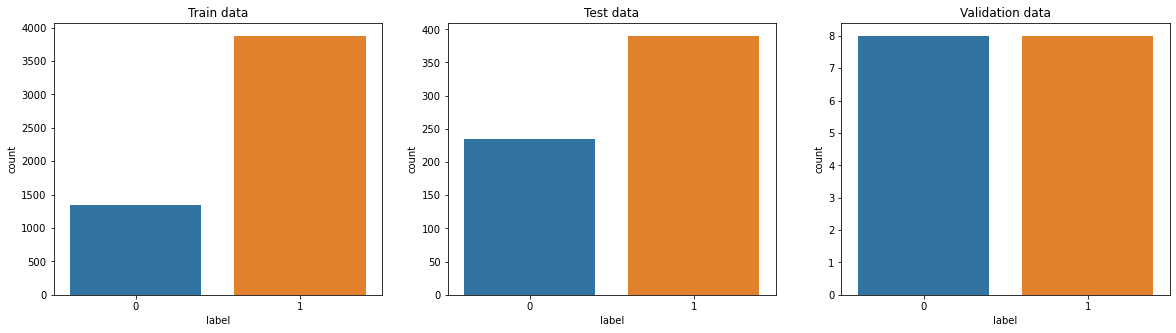

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.countplot(train_df['label'])
plt.title('Train data')

plt.subplot(1,3,2)
sns.countplot(test_df['label'])
plt.title('Test data')

plt.subplot(1,3,3)
sns.countplot(val_df['label'])
plt.title('Validation data')

plt.show()

###  Training data is highly imbalanced,testing data is slightly imbalanced and validation dataset is balanced.

# Visulaization of each cases

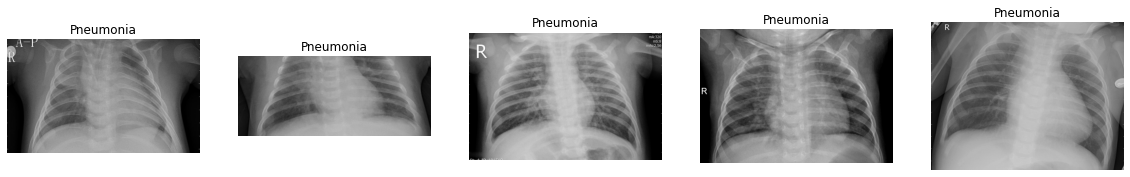

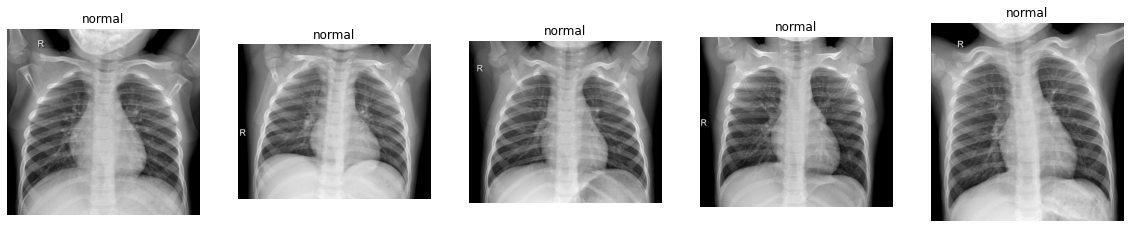

In [ ]:
plt.figure(figsize=(20,8))
for i ,img_path in enumerate(train_df[train_df['label'] == 1][0:5]['image']):
  plt.subplot(2,5,i+1)
  plt.axis('off')
  img=plt.imread(img_path)
  plt.imshow(img,cmap='gray')
  plt.title('Pneumonia')


plt.figure(figsize=(20,8))
for i,img_path in enumerate(train_df[train_df['label'] == 0][0:5]['image']):
  plt.subplot(2,5,5+i+1)
  plt.axis('off')
  img=plt.imread(img_path)
  plt.imshow(img,cmap='gray')
  plt.title('normal')





# Data Preprocessing

### we are going to prepare our data for modeling.  It involves two process:
            

* Process_data -  load image,resize it, convert to grayscale,normalize and reshape to dimension required to tensorflow
* Compose_dataset -  loop through images,generating 2 numpy array.First contains image itself as matrix,second contains label



In [ ]:
def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (150, 150))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (150,150,1))
    
    return img

def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

Using functions,let's prepare train ,test and validation arrays from dataframes

In [ ]:
X_train, y_train = compose_dataset(train_df)
X_test,  y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)
 

In [ ]:
print('Train data shape: {},Labels shape :{}'.format(X_train.shape ,y_train.shape))
print('Test data shape: {},Labels shape :{}'.format(X_test.shape ,y_test.shape))
print('Val data shape: {},Labels shape :{}'.format(X_val.shape ,y_val.shape))

Train data shape: (5216, 150, 150, 1),Labels shape :(5216,)
Test data shape: (624, 150, 150, 1),Labels shape :(624,)
Val data shape: (16, 150, 150, 1),Labels shape :(16,)


## Data Augmentation

In order to avoid overfitting problem ,we need to expand dataset artificially.We can make existing datasets much larger by data augmentaion techniques.

In [ ]:
# Image augmentation
#define generator
datagen= ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

datagen.fit(X_train)

## Modeling

In [ ]:
model=Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "Adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_20 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_16 (Dropout)         (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 38, 38, 64)       

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=2,factor=0.3,mode='max')
checkpoint=ModelCheckpoint(filepath="best_weights.hdf5",monitor='val_loss',save_best_only=True,save_weights_only=True)
early_stop=EarlyStopping(monitor='val_loss',min_delta=0.1,patience=1,mode="max")

In [ ]:
history = model.fit(
    datagen.flow(X_train,y_train, batch_size =32) ,
    epochs = 10 ,
    verbose=1, 
    validation_data = datagen.flow(X_val, y_val) ,
    callbacks = [learning_rate_reduction,checkpoint,early_stop])

Epoch 1/10
163/163 [==============================] - 123s 756ms/step - loss: 0.0722 - accuracy: 0.9741 - val_loss: 1.0594 - val_accuracy: 0.5625
Epoch 2/10
163/163 [==============================] - 123s 754ms/step - loss: 0.0741 - accuracy: 0.9741 - val_loss: 0.7417 - val_accuracy: 0.6875
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.9735
Epoch 00003: ReduceLROnPlateau reducing learning rate to 7.289999985005124e-07.
163/163 [==============================] - 134s 823ms/step - loss: 0.0795 - accuracy: 0.9735 - val_loss: 1.0354 - val_accuracy: 0.6875
Epoch 4/10
163/163 [==============================] - 153s 938ms/step - loss: 0.0678 - accuracy: 0.9768 - val_loss: 0.9675 - val_accuracy: 0.6250
Epoch 5/10
163/163 [==============================] - 131s 803ms/step - loss: 0.0715 - accuracy: 0.9749 - val_loss: 1.2889 - val_accuracy: 0.6250
Epoch 6/10
163/163 [==============================] - 126s 776ms/step - loss: 0.0756 - accuracy: 0.9730 -

In [ ]:

print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

20/20 [==============================] - 3s 140ms/step - loss: 0.3413 - accuracy: 0.9022
Loss of the model is -  0.34133675694465637
20/20 [==============================] - 3s 143ms/step - loss: 0.3413 - accuracy: 0.9022
Accuracy of the model is -  90.22436141967773 %


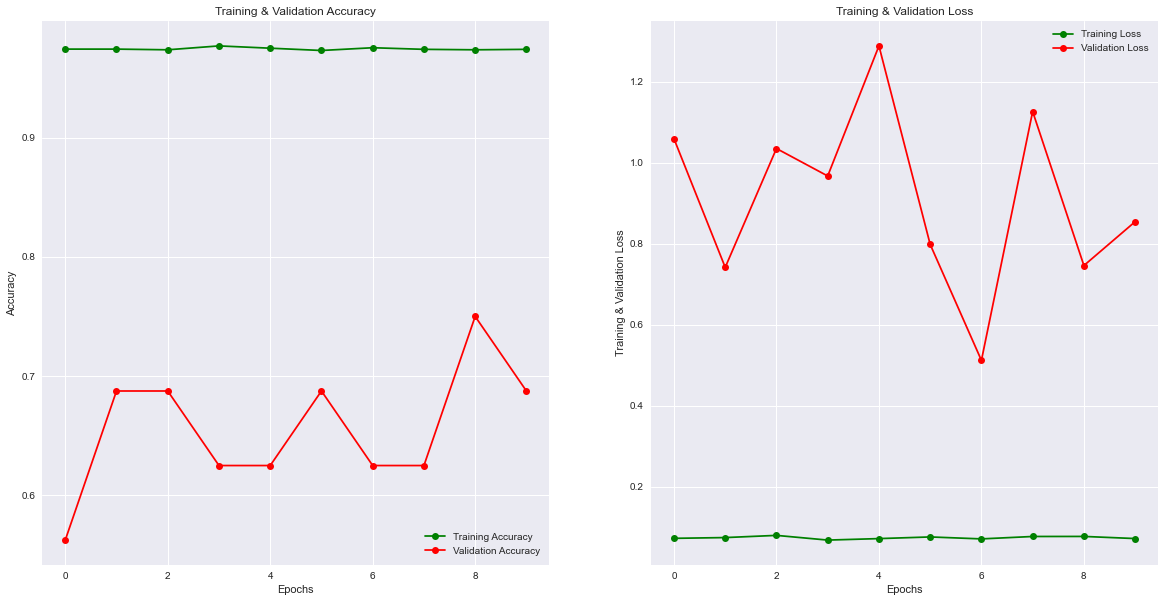

In [ ]:
#epochs = [i for i in range(12)]
#epochs = range(len(train_acc))
plt.style.use("seaborn")
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(len(train_acc))
fig.set_size_inches(20,10)


ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = model.predict_classes(X_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Normal (Class 0)','pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.95      0.78      0.86       234
pneumonia (Class 1)       0.88      0.98      0.93       390

           accuracy                           0.90       624
          macro avg       0.92      0.88      0.89       624
       weighted avg       0.91      0.90      0.90       624



In [ ]:
cm = confusion_matrix(y_test,predictions)
cm


array([[182,  52],
       [  9, 381]])

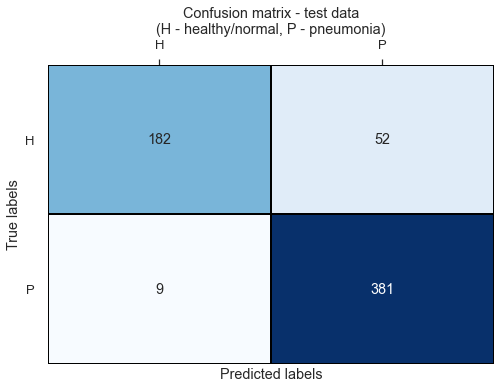

In [ ]:
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, annot=True,xticklabels=['H', 'P'], yticklabels=['H', 'P'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top') 
plt.title('Confusion matrix - test data\n(H - healthy/normal, P - pneumonia)')
plt.show()




Recall is 97% while precision in 87% so it can be considered as good model while the accuray is 90%.

In [ ]:
#recall
381/(381+9)

0.9769230769230769

In [ ]:
#precision
381/(381+52)

0.8799076212471132